# Titanic Machine Learning from Disaster

In [11]:
from zipfile import ZipFile
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import seaborn as sns

---
<h2 style="color:#5386E4">Problem Framing</h2>
The aim is to find a model that predicts which passengers survived the Titanic shipwreck based on their information. <br>
This is a typical *binary classification* problem (supervised) where a binary classifier can be used to classify two possible cases (Survived or Not Survived). Data is not too large, therefore, we will conduct batch learning.

---
<h2 style="color:#5386E4">Data Extraction</h2>

In [2]:
DOWNLOAD_ROOT = 'datasets'
def fetch_data(path=DOWNLOAD_ROOT):
    os.makedirs(path, exist_ok=True)
    os.system('kaggle competitions download -c titanic -p ' + path)
    zip_path = os.path.join(path, 'titanic.zip')
    with ZipFile(zip_path, 'r') as zip:
        zip.extractall(path=path)
        
def load_trainset_testset(path=DOWNLOAD_ROOT):
    train_path = os.path.join(path, 'train.csv')
    test_path = os.path.join(path, 'test.csv')
    
    return pd.read_csv(train_path), pd.read_csv(test_path)



In [4]:
fetch_data()
titanic_train, titanic_test = load_trainset_testset()

---
<h2 style="color:#5386E4">Exploratory Analysis</h2>

### Describe data

In [14]:
titanic_clone = titanic_train.copy()

titanic_train.info()
titanic_train.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
titanic_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


From the output above, we can see some data missing for age, thus, we have to deal with this later on in data preparation. I can see that some people got onto titanic for free. This may be plausible. Unfortunately, most people did not survive.

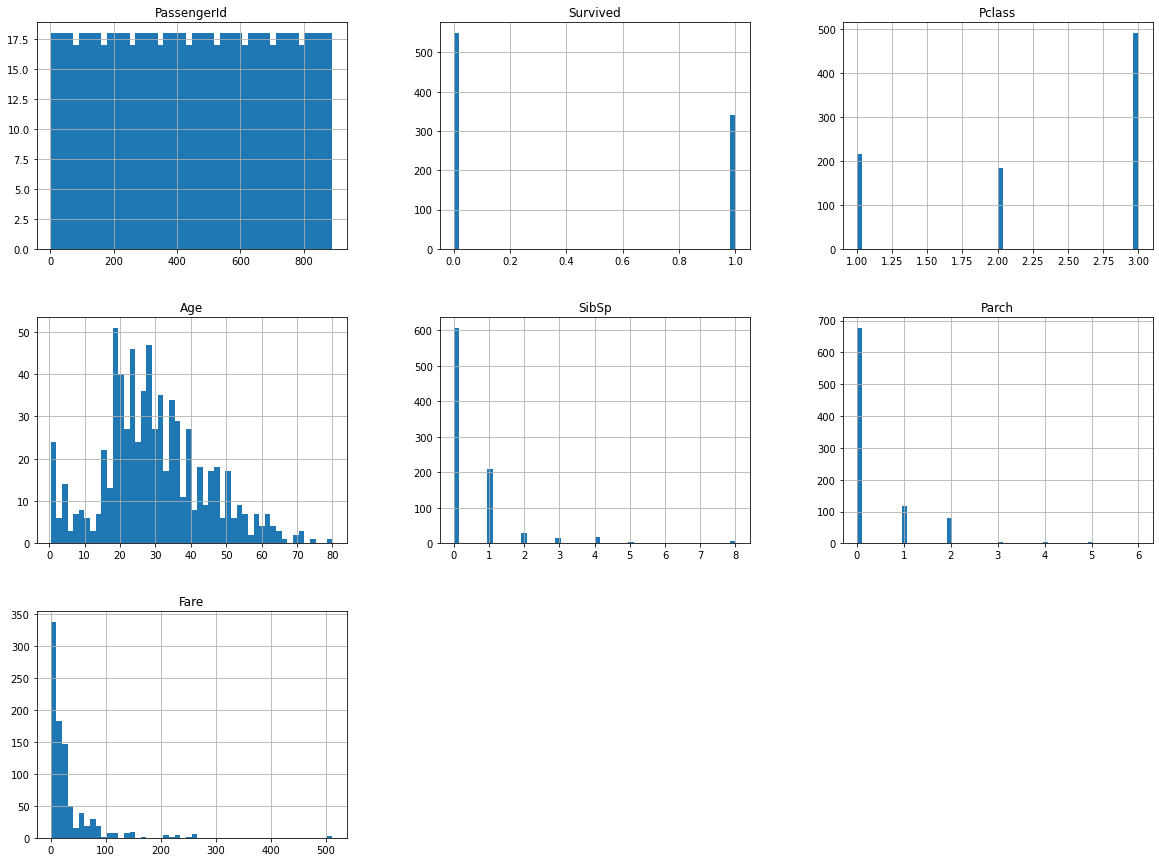

In [6]:
titanic_train.hist(bins=50, figsize=(20,15))
plt.show()

Analysis on Age

<AxesSubplot:xlabel='Age', ylabel='Density'>

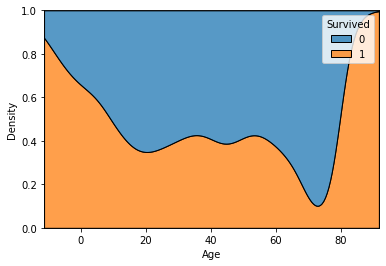

In [33]:
sns.kdeplot(data=titanic_clone, x="Age", hue="Survived", multiple='fill')

From this plot, you can see that as you age more, the less likely you would survive. (with a few exceptions)

### Analysis on Sex

,Survived
Sex,
female,0.742038
male,0.188908


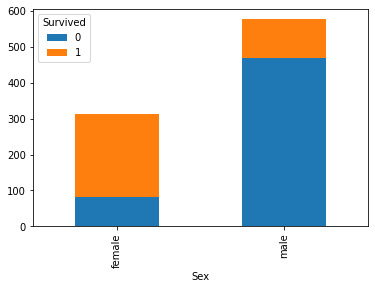

In [7]:
titanic_clone.pivot_table('PassengerId', 'Sex', 'Survived', 'count').plot(kind='bar', stacked=True)

titanic_clone.groupby(['Sex']).agg({'Survived': 'mean'})

Looks like female people were more likely to survive :(

Survived
Sex    Pclass          
female 1       0.968085
       2       0.921053
       3       0.500000
male   1       0.368852
       2       0.157407
       3       0.135447

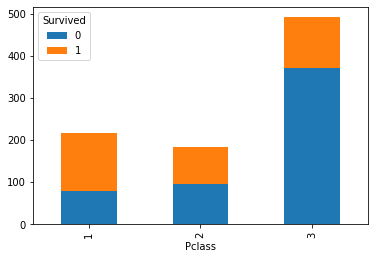

In [8]:
titanic_clone.pivot_table('PassengerId', 'Pclass', 'Survived', 'count').plot(kind='bar', stacked=True)
titanic_clone.groupby(['Sex', 'Pclass']).agg({'Survived': 'mean'})

Not surprising to see that people with 3rd ticket class were less likely to survive, given that 3rd ticket is the cheapest to get.

---
<h2 style="color:#5386E4">Data Preparation</h2>
As mentioned, there is some missing age so it has to be dealt with as well as other cateogical values. Also, all the categorical values need to be encoded in some way (most likely one-hot)<br>

In [53]:
titanic = titanic_train.drop(["Survived", "Name", "Ticket"] , axis=1)
titanic_labels = titanic_train["Survived"].copy()

In [50]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomImputer(BaseEstimator, TransformerMixin):
    '''
    class used for imputing missing values in a custom way.

    Parameteres
    --------
    target : str
        The name of the column(s) to impute
    metric : str
        The metric to be used for replacement which can be one of ['mean, 'median]
    '''

    def __init__(self, group_cols, metric='mean'):
        assert metric in ['mean', 'median'], 'Metric should be in [mean, median]'

        self.metric = metric
        self.group_cols = group_cols

    def fit(self, X, y=None):
        impute_map = titanic_train.groupby(['Sex','Pclass'])
        self.impute_map_ = impute_map

        return self

    def transform(self, X, y=None):
        X = X.copy()
        for cat in X.columns:
            if self.metric == 'median':
                X[cat] = self.impute_map_[cat].apply(lambda x: x.fillna(x.median()))
            else:
                X[cat] = self.impute_map_[cat].apply(lambda x: x.fillna(x.mean()))
        return X.values

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', CustomImputer(['Sex', 'Pclass'])),
    ('std_scaler', StandardScaler())
])

In [57]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('cat_imputer', SimpleImputer(strategy="most_frequent")),
    ('encoder', OneHotEncoder())
])

In [60]:
from sklearn.compose import ColumnTransformer

titanic_num = titanic.select_dtypes([np.number])
titanic_cat = titanic.select_dtypes('object')

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, list(titanic_num)),
    ("cat", cat_pipeline, list(titanic_cat))
])

titanic_prepared = full_pipeline.fit_transform(titanic)

---
<h2 style="color:#5386E4">Shortlisting models</h2>

In [61]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=69)
sgd_clf.fit(titanic_prepared, titanic_labels)

SGDClassifier(random_state=69)

array([1])

---
<h2 style="color:#5386E4">Fine-tuning models</h2>

---
<h2 style="color:#5386E4">Solution</h2>